# Test Facies Simulations Indicators

This file is meant to demonstrate the use of gstlearn by loading a numpy array, transform the continuous variable into a categorical variable (like a facies variable) and perform some calculations based on the grid organization (transition probabilities or connectivity)

## Before running this script make sure you known where libpyflumy module is available:
```
sys.path.append(os.environ['PYFLUMYDIR'])
```

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    // Remove Scrollbar in outputs
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# Show python version
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Load gstlearn module
from gstlearn import *
status = setup_license("Demonstration")
verbose = True

# Load pyflumy module (not yet a standard module)
sys.path.append(os.environ['PYFLUMYDIR'])
from pyflumy import *

Python version
3.8.5 (default, Sep 23 2020, 22:24:01) 
[GCC 5.4.0 20160609]
Version info.
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)


## Generate a Flumy simulation
Define functions for using and launching Flumy, then use the template simulation for Alpha reservoir. The simulated grid size is 6400m x 3200m with a 30m thickness

In [3]:
nx = 128
ny = 64
nxy = [nx,ny]
dx = dy = 50
nz = 40
dz = 0.5
hmax = 10
zul = nz*dz + hmax # Fill the required thickness + one channel thinkness

In [4]:
def print_params(param):
    print("Flumy parameters:")
    print("DOMAIN_NX =",       param.getParamInt("DOMAIN_NX"))
    print("DOMAIN_NY =",       param.getParamInt("DOMAIN_NY"))
    print("DOMAIN_DX =",       param.getParamDouble("DOMAIN_DX"))
    print("DOMAIN_DY =",       param.getParamDouble("DOMAIN_DY"))
    print("DOMAIN_SLOPE =",    param.getParamDouble("DOMAIN_SLOPE"))
    print("EROD_COEF =",       param.getParamDouble("EROD_COEF"))
    print("CHNL_WIDTH =",      param.getParamDouble("CHNL_WIDTH"))
    print("CHNL_WAVELENGTH =", param.getParamDouble("CHNL_WAVELENGTH"))
    print("CHNL_FLW_DIR =",    param.getParamDouble("CHNL_FLW_DIR"))
    print("AV_REG_FREQ =",     param.getParamInt("AV_REG_FREQ"))
    print("AV_REG_POISSON =",  param.getParamInt("AV_REG_POISSON"))
    print("AV_LOC_FREQ =",     param.getParamInt("AV_LOC_FREQ"))
    print("AG_OB_FREQ =",      param.getParamInt("AG_OB_FREQ"))
    print("AG_OB_POISSON =",   param.getParamInt("AG_OB_POISSON"))
    print("AG_OB_DIST =",      param.getParamDouble("AG_OB_DIST"))
    print("AG_OB_CONST =",     param.getParamDouble("AG_OB_CONST"))
    print("AG_LV_WIDTH =",     param.getParamDouble("AG_LV_WIDTH"))
    print("AG_EXP_DEC_THICK =",param.getParamDouble("AG_EXP_DEC_THICK"))

def perform_simu(zul, debug, seed):
    
    ################################
    # STEP 1 : Flumy configuration #
    ################################

    simu = iSimulator.createSimulator() # Create a Flumy simulator
    param = simu.getParameters()        # Get the parameters manager
    tracer = simu.getTracer()           # Get the tracer manager

    # General configuration
    tracer.setVerbose(debug > 0)   # Tells flumy to be speaky, or not
    tracer.setTraceLevel(debug)    # Tells flumy to be speaky, or not
    param.setUsingTurbi1()

    # Grid configuration
    param.setParamDouble(KEY_DOMAIN_OY, 0.0)         # origin's ordinate
    param.setParamDouble(KEY_DOMAIN_OX, 0.0)         # origin's abscissa
    param.setParamDouble(KEY_DOMAIN_ZREF, 0)         # reference elevation
    param.setParamInt(KEY_DOMAIN_NX, nx)             # number of nodes along X
    param.setParamInt(KEY_DOMAIN_NY, ny)             # number of nodes along Y
    param.setParamDouble(KEY_DOMAIN_DX, dx)          # grid's spacing along X
    param.setParamDouble(KEY_DOMAIN_DY, dy)          # grid's spacing along Y
    param.setParamDouble(KEY_DOMAIN_GRID_DIR, 0.0)   # grid's angle from X axis

    # Apply Nexus
    mc = MeanderCalculator(param, tracer)
    nxp = NexusParams()
    nxp._max_depth = hmax
    nxp._isbx = mc.default_isbx()
    nxp._sand = mc.default_sand()
    nxp._adaptgrid = False
    MeanderCalculator.apply_nexus(param, tracer, nxp)

    # Initialise the simulator
    simu.init()

    ################################
    # STEP 2 : Scenario parameters #
    ################################

    # Override default Nexus generated parameter
    param.setParamDouble(KEY_DOMAIN_SLOPE, 0.001) # Normal slope for Standard Turbidites scenario
    param.setParamDouble(KEY_CHNL_WIDTH, 350) # Constant channel width (which is big for a turbidite of hmax=10m)
    param.setParamInt(KEY_AV_REG_FREQ, 2) # Poisson period for regional avulsions
    param.setParamInt(KEY_AV_REG_POISSON, 110) # Regional avulsion every 110 iterations (in average)
    param.setParamInt(KEY_AG_OB_FREQ, 2) # Poisson period for overbank events
    param.setParamInt(KEY_AG_OB_POISSON, 140) # Overbank period every 140 iterations
    param.setParamDouble(KEY_AG_OB_CONST, 1) # Overbank intensity of 1m
    print_params(param)

    # Random number generator initialization
    param.setParamInt(KEY_SIM_SEED, seed)

    # Load upper limit surface z
    simu.loadUpperLimit(zul, ZUL_NEUTRAL)

    ##################################
    # STEP 3 : Launch the simulation #
    ##################################

    # Launch simulator
    simu.launch(100000)

    # Retrieve 3D regular grid of facies
    dom = simu.getDomain()
    facies = dom.getRegularFacies(dz, 0 ,nz)
    age =  dom.getRegularAge(dz, 0 ,nz)
    grain = dom.getRegularGrain(dz, 0 ,nz)

    # Delete simulator memory
    iSimulator.deleteSimulator(simu)

    # Convert Flumy facies to numpy array
    arr = np.asarray(facies).reshape((nx,ny,nz))
    arr[arr==3] = 2
    arr[arr==10] = 2
    arr[arr==7] = 3
    arr[arr==8] = 4
    
    return arr


In [5]:
# Execute one Flumy simulation
debug = 3 # Print information to jupyter server standard output
seed = 123456
arr = perform_simu(zul, debug, seed)

Flumy parameters:
DOMAIN_NX = 128
DOMAIN_NY = 64
DOMAIN_DX = 50.0
DOMAIN_DY = 50.0
DOMAIN_SLOPE = 0.001
EROD_COEF = 1.26e-08
CHNL_WIDTH = 350.0
CHNL_WAVELENGTH = 500.0
CHNL_FLW_DIR = 90.0
AV_REG_FREQ = 2
AV_REG_POISSON = 110
AV_LOC_FREQ = 2
AG_OB_FREQ = 2
AG_OB_POISSON = 140
AG_OB_DIST = 1e+30
AG_OB_CONST = 1.0
AG_LV_WIDTH = 6.0
AG_EXP_DEC_THICK = 3267.0


## Extract one slice from the facies array

Unique facies are  [255]


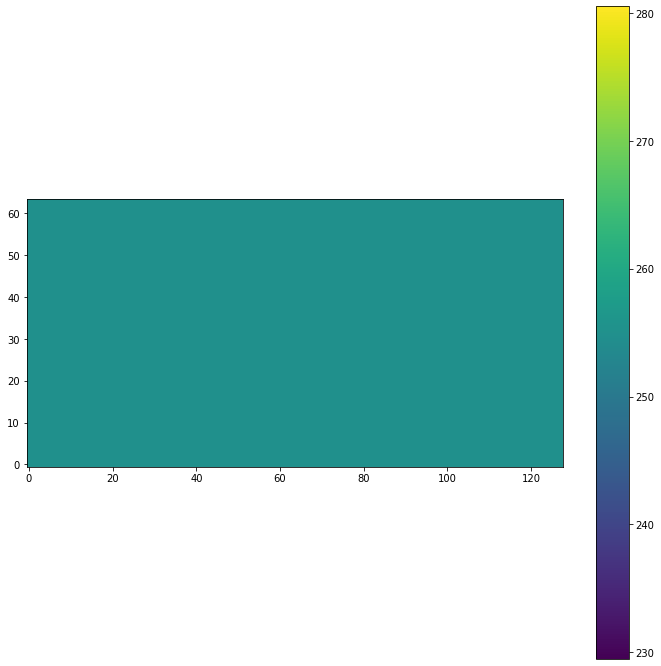

In [6]:
slice_idx = 35 # Beware: not all slices contain 4 facies
my_slice = arr[:,:,slice_idx]
arr_flat = my_slice.flatten()
ufacies = np.unique(arr_flat)
print("Unique facies are ", ufacies)
nfacies = len(ufacies) 

plt.rcParams["figure.figsize"] = (12,12)
plt.imshow(my_slice.T, origin='lower')
plt.colorbar()
plt.show()

## Import this array in gstlearn

The Grid file is created first (defining the origin, mesh size and count). Then the facies variable is added giving the name and the locator. 

In [7]:
ndim = 2
ASpaceObject.defineDefaultSpace(SPACE_RN, ndim)
grid = DbGrid.create([nx,ny],[dx,dy],[0,0])
grid.addColumns(np.double(arr_flat), "fac", ELoc.Z)
att_simu = grid.getLastUID()
if verbose:
    grid.display(FLAG_EXTEND | FLAG_STATS)


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Maximum Number of UIDs       = 4
Total number of samples      = 8192

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :     50.000    50.000
Number :        128        64

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = fac - Locator = z1
 

## Proportions
Calculate facies global proportions

In [8]:
simu = arr_flat
cnt = Counter(list(simu))
props = [100*cnt[f]/(nx*ny) for f in ufacies]
sprops = ["{:.2f}%".format(p) for p in props]
facs = ["Fac{}".format(f) for f in ufacies]
df = pd.DataFrame({'Facies': facs, 'Proportions': sprops})
print(df.to_string(index=False))

Facies Proportions
Fac255     100.00%


## Transition probabilities
Calculate the transition probabilities for the 2 main directions and for each facies identifier

In [9]:
limits = Limits(nfacies)
if verbose:
    limits.display()
err = limits.toIndicator(grid, "fac")
grid

Bound( 1 ) : [ 0.5 ; 1.5 [
 


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 5
Maximum Number of UIDs       = 5
Total number of samples      = 8192

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :     50.000    50.000
Number :        128        64

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = fac - Locator = NA
Column = 4 - Name = Indicator.fac.Class - Locator = z1

In [10]:
variop = VarioParam()
dir1 = DirParam(ndim,40,dx)
dir1.setGrincr([1,0])
dir2 = DirParam(ndim,20,dx)
dir2.setGrincr([0,1])
variop.addDirs(dir1)
variop.addDirs(dir2)
vario = Vario(variop,grid)
vario


Undefined

In [ ]:
err = vario.compute(gl.ECalcVario.TRANS1)
vario

In [ ]:
for idir in range(vario.getDirectionNumber()):
    for ifac in range(nfacies):
        for jfac in range(ifac):
            if ifac != jfac:
                hh = vario.getHhVec(idir,ifac,jfac)
                gg = vario.getGgVec(idir,ifac,jfac)
                plt.plot(hh,gg)
                plt.title("Transition probabilities in dir #" + str(idir+1) + " leaving F" + str(ifac+1) + " / entering F" + str(jfac+1))
                plt.show()

## Connected Components
Calculate the connected components for each facies.

In [ ]:
eps = 0.5
compnum = grid.getColumnByUID(att_simu)
for fac in ufacies:
    vmin = fac - eps
    vmax = fac + eps
    image   = morpho_double2image(nxy,compnum,vmin,vmax);
    compnew = morpho_labelling(nxy,0,0,image,TEST)
    compnew = [np.nan if x==TEST else x for x in compnew]
    sizes   = morpho_labelsize(nxy,0,image)

    plt.imshow(np.reshape(compnew, nxy).T, origin="lower", cmap='hot')
    plt.colorbar()
    plt.title("Connected components for F{}".format(fac))
    plt.show()

    plt.hist(sizes, bins = 50)
    plt.title("Size of connected component for F{}".format(fac))
    plt.show()